# Demonstration: using demosaicing to detect demosaicing

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DentanJeremie/demosaicing-detection/blob/main/doc/configuration_detection_demonstration.ipynb)

**Author:** Jérémie Dentan

This notebook illustrates some experiments made by the author for his review of a paper from Quentin Bammey, Rafael Grompone von Gioi and Jean-Michel Morel. 

-  The review, *Towards a reliable detection of forgeries based on demosaicing*: [http://dx.doi.org/10.13140/RG.2.2.17584.02568](http://dx.doi.org/10.13140/RG.2.2.17584.02568)
-  The original paper, *Demosaicing to Detect Demosaicing and Image Forgeries*: [https://doi.org/10.1109/WIFS55849.2022.9975454](https://doi.org/10.1109/WIFS55849.2022.9975454)
-  The repository containing the source code for this notebook: [https://github.com/DentanJeremie/demosaicing-detection](https://github.com/DentanJeremie/demosaicing-detection)

## Introduction

The goal of this notebook is to illustrate a method to detect the demosaicing of images. This notebook provides a minimal piece of code to reproduce some limitations of this method, as well as example where the method works as expected.

More precisely, in this notebook we will:
-   Provide an example of true detection of the demosaicing configuration, whithout JPEG compression.
-   Provide an example of false detection of the demosaicing configuration, in the presence of JPEG compression. The problem is that those false detection come with relly low NFA value, which mean really high confidence in the detection.

**Explainations:**

-   Those really low NFA value for the false detection probably come from the fact that some algorithms are intrinsically better than other at recontructing the colors. 
-   When the image is compressed, the demosaicing artefacts are less visible, so the true algorithm is less favored for the votes. Thus, a lot of $2 \times 2$ blocks vote for the most performant algorithm rather than one that left some hardly-detectable demosaicing artefacts.
-   Thus, the hypotheses of uniform likelihood of the algorithms that is made by the a contrario model are contradicted. This is why we observe those really low NFA values.

**Few implementation details:**
* The three demosaicing we tested here are the one implemented in the Python Library `colour-demosaicing`: `bilinear` (simple bilinear interpolation of the colours), `malvar` (paper "High-quality linear interpolation for demosaicing of bayer-patterned colour images", Malvar et al, 2004), and `menon` (paper "Demosaicing with directional filtering and a posteriori decision", Menon et al, 2007). Admittedly, those are ancient, old demosaicing algorithms. However, if we can observe those limitations with those simple algorithms, there is no reason why they would bo fully absent with in a collection of more recent algorithms.
* The four patters we test are all Bayer CFA patterns: `RGGB`, `BGGR`, `GRBG`, `GBRG`
* When there is a tie for the approximation of a 2x2 block, the tie is breaken using a random choice among all configurations that minimize the mean of the absolute L1 reconstruction error.

## Set up

You should run this notebook with `Python 3.9`. Moreover, this notebook is supposed to work with the code of repository [https://github.com/DentanJeremie/demosaicing-detection](https://github.com/DentanJeremie/demosaicing-detection), having the dependencies in `requirements.txt` installed and with your PYTHONPATH set to the root of the repository.

The following lines should do this for you. The first outputed line after the verbose should be a path to the root of the repository:
- Set variable `STANDALONE` to `True` if you are using this notebook outside its original Git repository; else set it to `False`. If `True`, the repository will be cloned to be able to use the methods it implements for demosaicing and forgery detection;
- Set variable `MESSY_ENV` to `True` is you are using a Python environment with already a lots of library installed, **which is the case if you're using Google Colab**. If you're working with a new environment, as we encourage you to do, set it to `False`. For a messy environment, the dependencies will be installed without enforcing the versions, so we cannot guarantee that you will be able to exactly reproduce our results. 

**This is why, to be sure to reproduce exactly our results, we advise you to use a new Python virtual environment with `MESSY_ENV=False`.**

In [1]:
STANDALONE = True # True if you're using this notebook outside its original repository, else False
MESSY_ENV = True # True is you're using a Python env with many libs already installed (e.g. you're on Colab), else False

In [2]:
from pathlib import Path
import os

REPO_NAME = 'demosaicing-detection'
REQUIREMENTS = 'requirements.txt'
REQUIREMENTS_FOR_MESSY = str(Path('doc/colab_requirements_noversion.txt'))

# If all of this already have been done
if Path(os.getcwd()).name == REPO_NAME and Path('requirements.txt').exists():
    print('We are already at the root of the repo!')
    STANDALONE = False

# If we need to clone the repo but it's already here
if STANDALONE and Path(REPO_NAME).exists():
    print("The repository already exists!")
    STANDALONE = False
    os.chdir(REPO_NAME)
    assert Path(REQUIREMENTS).exists(), "There exists an incomplete version of the repository, please delete it and try again"

# If we need to clone the repo and it isn't here
os.environ['STANDALONE'] = str(STANDALONE)
!if [ "$STANDALONE" = "True" ]; then git clone https://github.com/DentanJeremie/demosaicing-detection; fi
if STANDALONE:
    os.chdir(REPO_NAME)
    STANDALONE = False

# If the notebook is already in the repo, we simply need to move to the root
if not STANDALONE:
    while not (Path('requirements.txt')).exists():
        os.chdir('..')

# Installing dependencies, setting PYTHONPATH
print('This should be the root of the repo:')
!pwd
!export PYTHONPATH=$(pwd)
os.environ['PROJECT_DEPENDENCIES'] = REQUIREMENTS if not MESSY_ENV else REQUIREMENTS_FOR_MESSY
%pip install -r $PROJECT_DEPENDENCIES --quiet
print("All dependencies have been installed, you're ready to go!")

This should be the root of the repo:
/Users/jeremie/Documents/02-Scolarité/01-MVA/03-Cours_S2/03-DetectionTheory/demosaicing-detection
Note: you may need to restart the kernel to use updated packages.
All dependencies have been installed, you're ready to go!


In [3]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import binom

from src.utils.constants import *
from src.utils.datasets import no_noise_dataset, dall_e_dataset
from src.forgery_tools.forge import forge
from src.forgery_tools.vote import get_block_votes, get_block_votes_on_algo
from src.forgery_tools.detect import detect_config

%matplotlib inline
np.random.seed(42)

        5661ms INFO  [datasets.py] Initiating a dataset over the no_noise_dataset dataset
        5663ms INFO  [datasets.py] More info at https://mcolom.perso.math.cnrs.fr/pages/no_noise_images/
        5665ms INFO  [datasets.py] Initiating a dataset over the dall_e_images dataset
        5666ms INFO  [datasets.py] More info at https://gist.github.com/DentanJeremie/21bfd925c5234afd15d854135b569bec
        5689ms INFO  [datasets.py] dataset found at /data/no_noise_images


## First example: using demosaicing to detect demosaicing

First, let's have a look at an example where the detection of the demosaicing works well. For a more complete description of the method, please refer to our report (cf. above).

-   First, we generate an image while controlling the demosaicing artefacts it presents:
    -  We take an image from the dataset. Due to some processing steps for the production of this dataset, the image is supposed to be free of any demosaicing artefacts.
    -   Then, we forge the image to imitate the demosaicing artefacts that would have been left by a camera during the caption of the image. The advantage of this process is that we can control the algorithm and the pattern used. In this case, we will use the algorithm `malvar` with pattern `GRBG`.
    -   We will apply no JPEG compression after that.
-   Then, we try to detect this configuration:
    -   We forge the image again, with 12 different demosaicing configuration
    -   We divide the pixels in $2 \times 2$ blocks, and each block vote for the configuration that has the lowest reconstruction error
    -   We take the configuration that has the majority of votes, and quantify the quality of the detection with a NFA.

In [4]:
# Fixing random generator for reproducibility
np.random.seed(42)

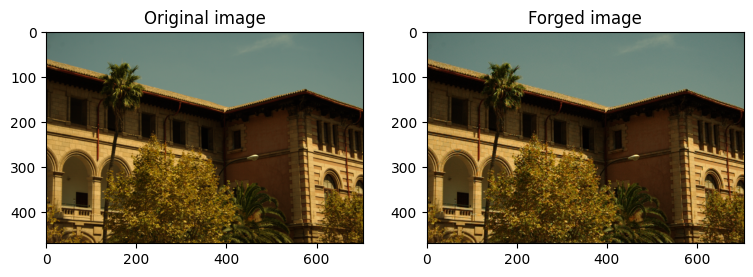

In [5]:
# Generating the image
image = no_noise_dataset[0]
demosaiced_image = forge(
    image,
    demosaicing_algo='malvar',
    pattern='GRBG',
    jpeg_compression=None,
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,6))
for img, title, ax in zip([image, demosaiced_image], ['Original image', 'Forged image'], axes.flatten()):
    ax.imshow(img)
    ax.set_title(title)

plt.show()
plt.close()

**1.** First, we see that we detect the configuration (`bilinear`, `RGGB`) with NFA=0, which is the true configuration that was to be detected. In fact, we observe that nearly all blocks have voted for the correct configuration. This illustrates the fact that the method works perfectly in the absence of JPEG compression.

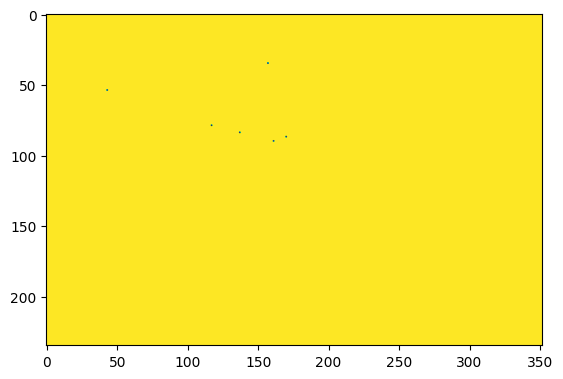

Votes for each of the 12 configurations (algo, pattern):
2:6
6:82714
Num votes = 82720
Detection: 6 with -log(NFA)=inf
Double check: 12 * binom.sf(82714, 82720, 1/12) = 0.0


In [6]:
votes = get_block_votes(demosaiced_image) # The votes for the configuration (algo, pattern) as int between 0 and 11
plt.imshow(votes)
plt.show()
plt.close()
print('Votes for each of the 12 configurations (algo, pattern):')
votes_count = 0
for value, count in zip(*np.unique(votes, return_counts=True)):
    print(f'{value}:{count}')
    votes_count += count
print(f'Num votes = {votes_count}')
config, nfa = detect_config(votes, len(ALGO_PATTERN_CONFIG)) # Detection of the algorithm: -1 for no detection
print(f'Detection: {config} with -log(NFA)={nfa}')
print(f'Double check: 12 * binom.sf(82714, 82720, 1/12) = {12 * binom.sf(82714, 82720, 1/12)}')

**2.** Then, we see that we detect the algorithm `bilinear` with NFA=0, which is the true algorithm that was to be detected.

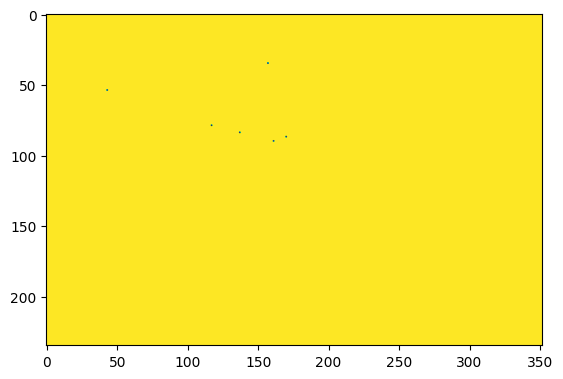

Votes for each of the 3 configurations of algorithm:
0:6
1:82714
Detection: 1 with -log(NFA)=inf
Double check: 3 * binom.sf(82714, 82720, 1/3) = 0.0


In [7]:
# Detecting the algorithm
votes_algo = get_block_votes_on_algo(votes) # The vote for the best algo, as int between 0 and 2
plt.imshow(votes_algo)
plt.show()
plt.close()
print('Votes for each of the 3 configurations of algorithm:')
votes_count = 0
for value, count in zip(*np.unique(votes_algo, return_counts=True)):
    print(f'{value}:{count}')
    votes_count += 1

config, nfa = detect_config(votes_algo, len(DEMOSAICING_ALGOS)) # Detection of the algorithm: -1 for no detection
print(f'Detection: {config} with -log(NFA)={nfa}')
print(f'Double check: 3 * binom.sf(82714, 82720, 1/3) = {3 * binom.sf(82714, 82720, 1/3)}')

## Limitation of the method: when we add JPEG compression

Now, we will show that some demosaicing algorithms are intrinsically better than other, which lead to their false detection when we add JPEG compression. The problem with those false detection is that they come with very low NFA values, which mean a really high confidence in the false detection.

More specifically, we will:
-   Apply a first step of mosaicing-demosaicing with the `bilinear` algorithm and pattern `RGGB`
-   Apply a JPEG compression of quality 95 on the obtained image (those two steps are done by the function `forge`)
-   Get the votes of the 2x2 blocks, and see that we detect the `malvar` algorithm with pattern `RGGB`

This shows that the `malvar` algorithms is instrisically better than `bilinear` at reconstructing the colors of an image after a JPEG compression, which makes the uniform assumption of the a-contrario model biased, leading to false detection of the `malvar` algorithm.

In [8]:
np.random.seed(42)

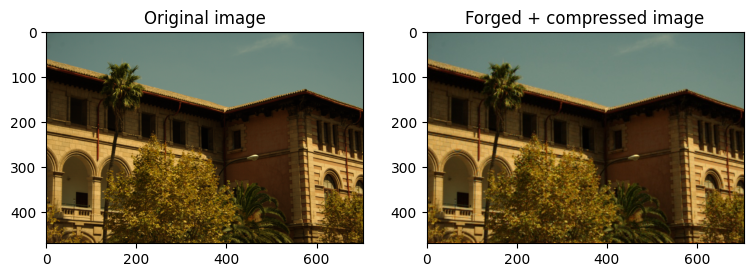

In [9]:
image = no_noise_dataset[0]
demosaiced_and_compressed = forge(
    image,
    demosaicing_algo='bilinear',
    pattern='RGGB',
    jpeg_compression=95,
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,6))
for img, title, ax in zip([image, demosaiced_and_compressed], ['Original image', 'Forged + compressed image'], axes.flatten()):
    ax.imshow(img)
    ax.set_title(title)

plt.show()
plt.close()

1. Let's check the reconstruction error. We see that it is lower for the false configuration, which is consistent with our hypothesis that some algorithms are inherently better.

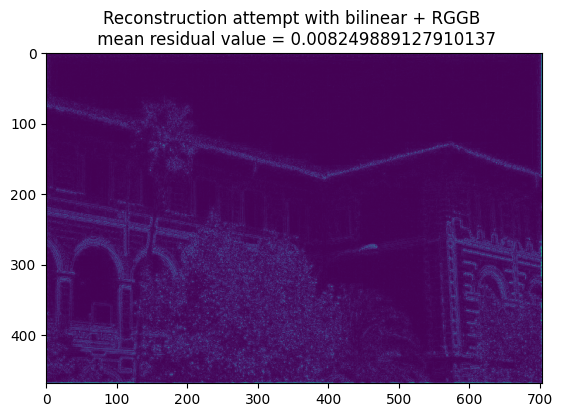

In [10]:
reconstruction_same_algo = forge(
    image=demosaiced_and_compressed,
    demosaicing_algo='bilinear',
    pattern='RGGB',
)
residual = np.abs(demosaiced_and_compressed - reconstruction_same_algo)
residual_one_channel = np.mean(residual, axis=2)

plt.imshow(residual_one_channel)
plt.title(f'Reconstruction attempt with bilinear + RGGB \n mean residual value = {np.mean(residual_one_channel)}')
plt.show()
plt.close()

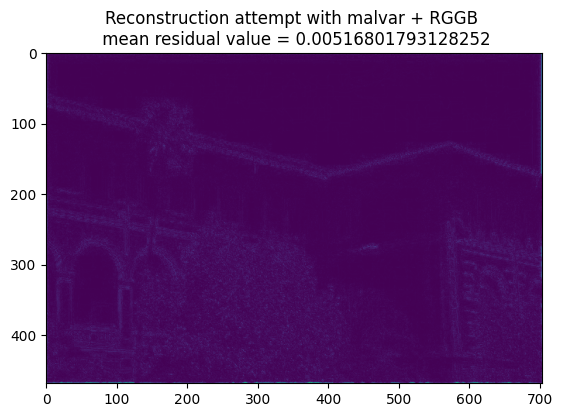

In [11]:
reconstruction_other_algo = forge(
    image=demosaiced_and_compressed,
    demosaicing_algo='malvar',
    pattern='RGGB',
)
residual = np.abs(demosaiced_and_compressed - reconstruction_other_algo)
residual_one_channel = np.mean(residual, axis=2)

plt.imshow(residual_one_channel)
plt.title(f'Reconstruction attempt with malvar + RGGB \n mean residual value = {np.mean(residual_one_channel)}')
plt.show()
plt.close()

**We observe a difference in the mean reconstruction error (0.0052 vs 0.0082). This will lead to the detection of the wrong algorithm in the a-contrario setting.**

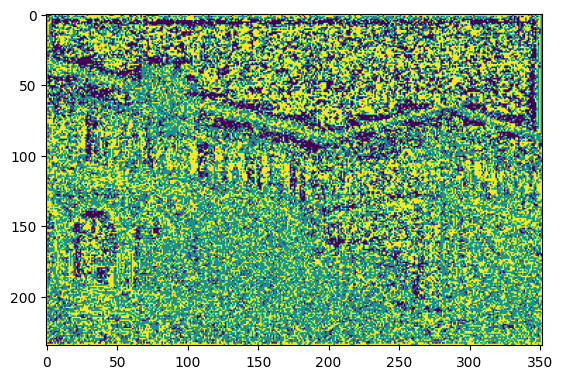

Votes for each of the 3 configurations of algorithm:
0:17191
1:33727
2:31802
Detection: 1 with -log(NFA)=inf
Double check: 3 * binom.sf(33727, 82720, 1/3) = 0.0


In [12]:
# Detecting the algorithm
votes = get_block_votes(demosaiced_and_compressed)
votes_algo = get_block_votes_on_algo(votes) # The vote for the best algo, as int between 0 and 2
plt.imshow(votes_algo)
plt.show()
plt.close()
print('Votes for each of the 3 configurations of algorithm:')
votes_count = 0
for value, count in zip(*np.unique(votes_algo, return_counts=True)):
    print(f'{value}:{count}')
    votes_count += 1

config, nfa = detect_config(votes_algo, len(DEMOSAICING_ALGOS)) # Detection of the algorithm: -1 for no detection
print(f'Detection: {config} with -log(NFA)={nfa}')
print(f'Double check: 3 * binom.sf(33727, 82720, 1/3) = {3 * binom.sf(33727, 82720, 1/3)}')

## One example with the `dall_e_images` dataset

Finally, let's provide an example with the `dall_e_images` dataset. Those images are computer-generated, so they are for sure free of any demosaicing artefacts. However, we see that we still observe some false detection of demosaicing. This proves that the false detections we observe previously do not come from supposed demosaicing artefacts that would remain in the `no_noise_images` dataset.

Thus, with this image, we observe the false detection of algorithm `bilinear` with pattern `GRBG`, with a really low NFA of $10^{-6.7}$

In [13]:
# Fixing random generator for reproducibility
np.random.seed(42)

       11497ms INFO  [datasets.py] dataset found at /data/dall_e_images


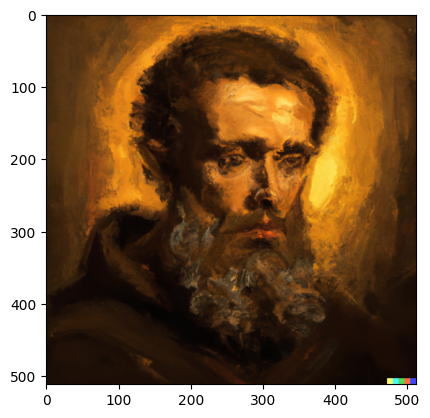

In [14]:
image = dall_e_dataset[0]

plt.imshow(image)
plt.show()
plt.close()

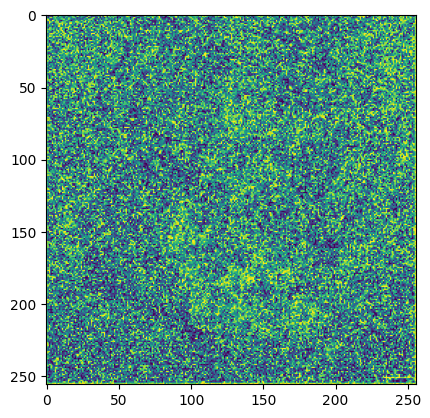

Votes for each of the 12 configurations (algo, pattern):
0:5853
1:5719
2:5856
3:5818
4:5259
5:5353
6:5397
7:5274
8:5388
9:5323
10:5204
11:5092
Num votes = 65536
Detection: 2 with -log(NFA)=6.71034336008631
Double check: 12 * binom.sf(5856, 65536, 1/12) = 1.9483036310156115e-07


In [15]:
votes = get_block_votes(image) # The votes for the configuration (algo, pattern) as int between 0 and 11
plt.imshow(votes)
plt.show()
plt.close()
print('Votes for each of the 12 configurations (algo, pattern):')
votes_count = 0
for value, count in zip(*np.unique(votes, return_counts=True)):
    print(f'{value}:{count}')
    votes_count += count
print(f'Num votes = {votes_count}')
config, nfa = detect_config(votes, len(ALGO_PATTERN_CONFIG)) # Detection of the algorithm: -1 for no detection
print(f'Detection: {config} with -log(NFA)={nfa}')
print(f'Double check: 12 * binom.sf(5856, 65536, 1/12) = {12 * binom.sf(5856, 65536, 1/12)}')

**Here, we clearly see the false detection of demosaicing even when it is absent.**